In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor

import joblib

In [4]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
sample_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")

stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
holidays_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
transactions_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [8]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [11]:
train_df.isna().sum().head(15)

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

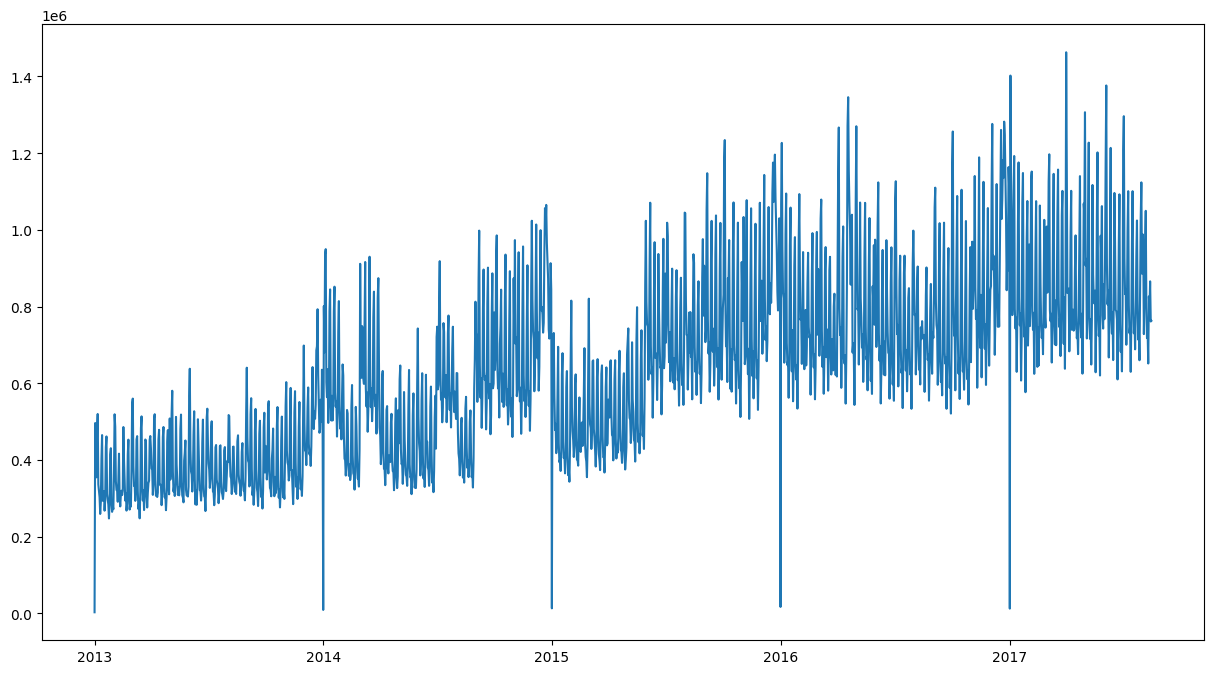

In [15]:
salesovertime=train_df.groupby(['date']).agg({'sales':'sum'}).reset_index()
plt.figure(figsize=(15,8))
plt.plot(salesovertime['date'],salesovertime['sales'])
plt.show()

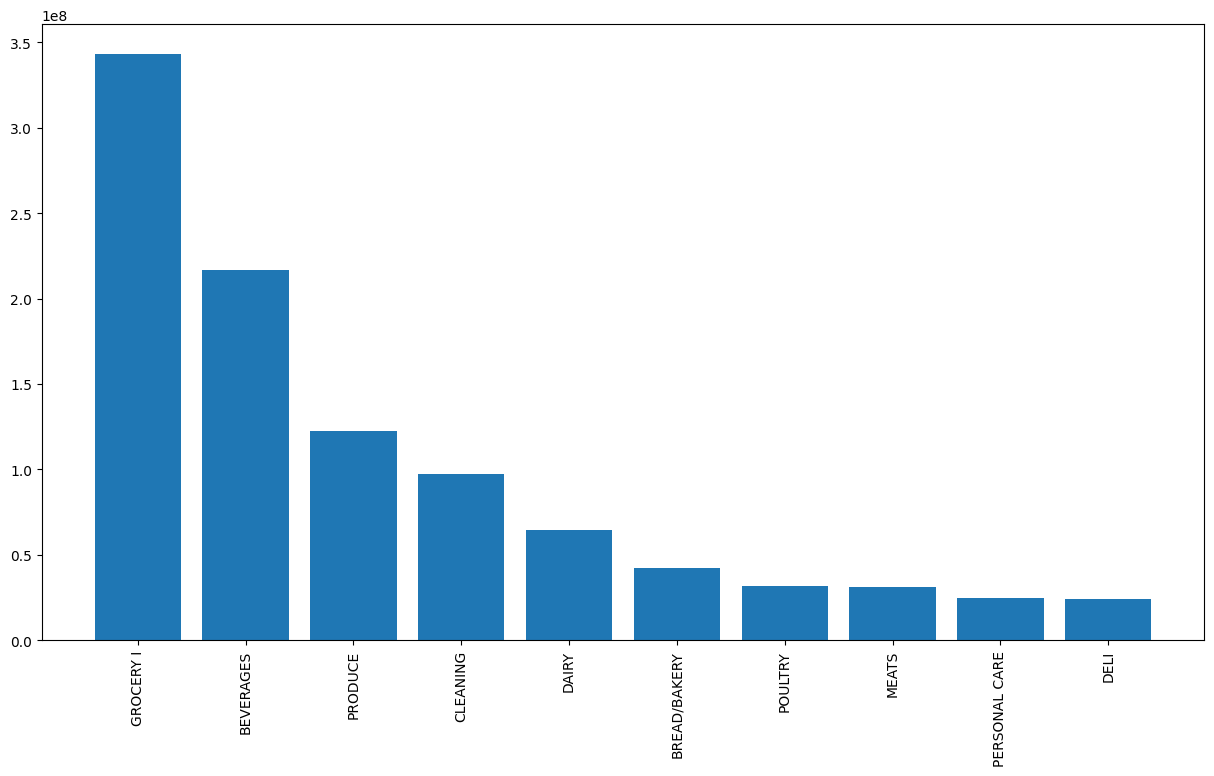

In [19]:
salesovertime1=train_df.groupby(['family']).agg({'sales':'sum'}).reset_index().sort_values('sales',ascending=False).head(10)
plt.figure(figsize=(15,8))
plt.bar(salesovertime1['family'],salesovertime1['sales'])
plt.xticks(rotation=90)
plt.show()

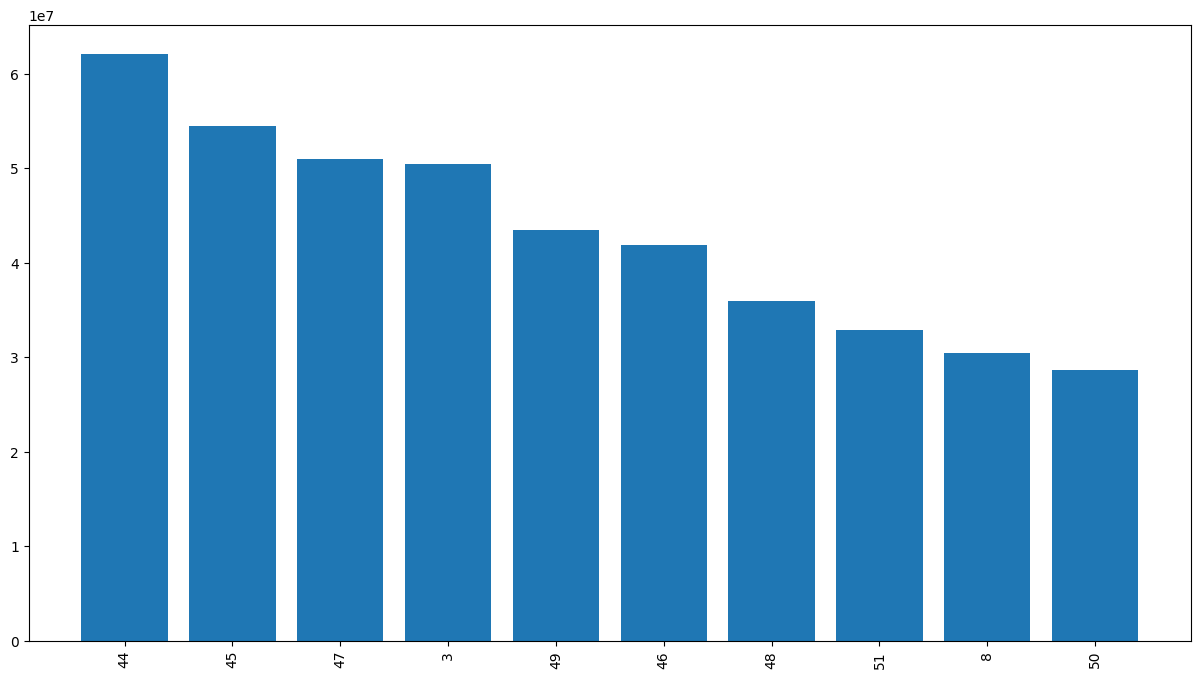

In [21]:
salesovertime3=train_df.groupby(['store_nbr']).agg({'sales':'sum'}).reset_index().sort_values('sales',ascending=False).head(10)
plt.figure(figsize=(15,8))
plt.bar(salesovertime3['store_nbr'].astype(str),salesovertime3['sales'])
plt.xticks(rotation=90)
plt.show()

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [25]:
hol = holidays_df.copy()
hol.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [26]:
hol = hol[hol["transferred"] == False].copy()

In [28]:
hol["is_holiday"] = 1
hol["is_national_holiday"] = (hol["locale"] == "National").astype(int)
hol["is_regional_holiday"] = (hol["locale"] == "Regional").astype(int)
hol["is_local_holiday"] = (hol["locale"] == "Local").astype(int)

In [29]:
hol

,date,type,locale,locale_name,description,transferred,is_holiday,is_national_holiday,is_regional_holiday,is_local_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1,0,0,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,0,1,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1,0,0,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0,0,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,1,0,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,1,0,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,1,0,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,1,0,0


In [30]:

hol_agg = hol.groupby("date", as_index=False).agg(
    is_holiday=("is_holiday", "max"),
    is_national_holiday=("is_national_holiday", "max"),
    is_regional_holiday=("is_regional_holiday", "max"),
    is_local_holiday=("is_local_holiday", "max"))

display(hol_agg.head())

,date,is_holiday,is_national_holiday,is_regional_holiday,is_local_holiday
0,2012-03-02,1,0,0,1
1,2012-04-01,1,0,1,0
2,2012-04-12,1,0,0,1
3,2012-04-14,1,0,0,1
4,2012-04-21,1,0,0,1


In [31]:
def add_date_features(df):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

In [32]:
def prepare_base(train_df, test_df, stores_df, oil_df, hol_agg, transactions_df):
    df_train = train_df.copy()
    df_test = test_df.copy()

    df_train["is_test"] = 0
    df_test["is_test"] = 1
    df_test["sales"] = np.nan

    df = pd.concat([df_train, df_test], ignore_index=True)

    oil = oil_df.sort_values("date").copy()
    oil["dcoilwtico"] = oil["dcoilwtico"].interpolate(limit_direction="both")

    df = df.merge(stores_df, on="store_nbr", how="left")
    df = df.merge(transactions_df, on=["date", "store_nbr"], how="left")
    df = df.merge(oil, on="date", how="left")
    df = df.merge(hol_agg, on="date", how="left")

    df["transactions"] = df["transactions"].fillna(0)
    df["dcoilwtico"] = df["dcoilwtico"].fillna(df["dcoilwtico"].median())

    df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)
    df["is_national_holiday"] = df["is_national_holiday"].fillna(0).astype(int)
    df["is_regional_holiday"] = df["is_regional_holiday"].fillna(0).astype(int)
    df["is_local_holiday"] = df["is_local_holiday"].fillna(0).astype(int)

    df = add_date_features(df)

    for c in ["family", "city", "state", "type"]:
        df[c] = df[c].astype("category")

    return df

In [33]:
df = prepare_base(train_df, test_df, stores_df, oil_df, hol_agg, transactions_df)
df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,city,state,type,...,is_holiday,is_national_holiday,is_regional_holiday,is_local_holiday,year,month,day,dayofweek,weekofyear,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Quito,Pichincha,D,...,1,1,0,0,2013,1,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Quito,Pichincha,D,...,1,1,0,0,2013,1,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Quito,Pichincha,D,...,1,1,0,0,2013,1,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,...,1,1,0,0,2013,1,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,Quito,Pichincha,D,...,1,1,0,0,2013,1,1,1,1,0


In [36]:
g = df.groupby(list(group_cols), sort=False, observed=False)

In [39]:
def add_lag_features(df, group_cols=("store_nbr", "family")):
    df = df.sort_values(list(group_cols) + ["date"]).copy()
    g = df.groupby(list(group_cols), sort=False, observed=False)

    df["sales_lag_1"] = g["sales"].shift(1)
    df["sales_lag_7"] = g["sales"].shift(7)
    df["sales_lag_14"] = g["sales"].shift(14)

    df["sales_rollmean_7"] = g["sales"].transform(lambda s: s.shift(1).rolling(7).mean())
    df["sales_rollmean_14"] = g["sales"].transform(lambda s: s.shift(1).rolling(14).mean())

    df["promo_lag_1"] = g["onpromotion"].shift(1)
    df["promo_lag_7"] = g["onpromotion"].shift(7)

    cols = ["sales_lag_1","sales_lag_7","sales_lag_14","sales_rollmean_7","sales_rollmean_14","promo_lag_1","promo_lag_7"]
    for c in cols:
        df[c] = df[c].fillna(0)
    return df


In [40]:
df = add_lag_features(df)


In [41]:
train_all = df[df["is_test"] == 0].copy()
test_all = df[df["is_test"] == 1].copy()

In [42]:
cutoff_date = train_all["date"].max() - pd.Timedelta(days=16)
train_part = train_all[train_all["date"] <= cutoff_date].copy()
valid_part = train_all[train_all["date"] > cutoff_date].copy()

In [43]:
train_part.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_test',
       'city', 'state', 'type', 'cluster', 'transactions', 'dcoilwtico',
       'is_holiday', 'is_national_holiday', 'is_regional_holiday',
       'is_local_holiday', 'year', 'month', 'day', 'dayofweek', 'weekofyear',
       'is_weekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_rollmean_7', 'sales_rollmean_14', 'promo_lag_1', 'promo_lag_7'],
      dtype='object')

In [49]:
feature_cols=['store_nbr', 'family', 'onpromotion', 'is_test',
       'city', 'state', 'type', 'cluster', 'transactions', 'dcoilwtico',
       'is_holiday', 'is_national_holiday', 'is_regional_holiday',
       'is_local_holiday', 'year', 'month', 'day', 'dayofweek', 'weekofyear',
       'is_weekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_rollmean_7', 'sales_rollmean_14', 'promo_lag_1', 'promo_lag_7']

In [50]:
missing = [c for c in feature_cols if c not in train_part.columns]
print(missing)

[]


In [51]:
x_train=train_part[feature_cols]
y_train = np.log1p(train_part["sales"].values)

In [52]:
x_valid = valid_part[feature_cols]
y_valid = np.log1p(valid_part["sales"].values)

In [53]:
model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42)

In [54]:
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric="rmse")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 2972376, number of used features: 26
[LightGBM] [Info] Start training from score 2.919643


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=3000,
              num_leaves=128, random_state=42, reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [55]:
pred_valid = np.expm1(model.predict(x_valid))
pred_valid = np.clip(pred_valid, 0, None)


In [56]:
rmsle = np.sqrt(mean_squared_log_error(valid_part["sales"].values, valid_part["sales"].values))

In [57]:
rmsle

np.float64(0.3656210502023183)

In [60]:
y_true = valid_part["sales"].values
y_pred = pred_valid

mask = y_true != 0


In [61]:
mape = np.mean(
    np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])
) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 30.41%


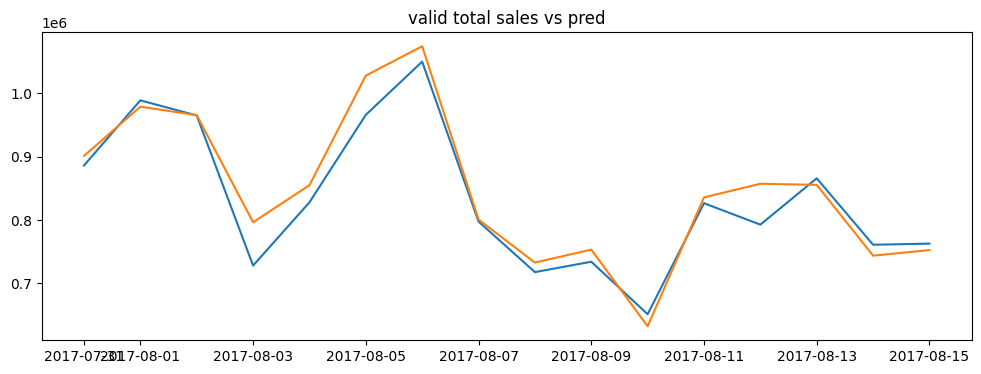

In [62]:
tmp = valid_part[["date","sales"]].copy()
tmp["pred"] = pred_valid
agg = tmp.groupby("date", as_index=False)[["sales","pred"]].sum()

plt.figure(figsize=(12,4))
plt.plot(agg["date"], agg["sales"])
plt.plot(agg["date"], agg["pred"])
plt.title("valid total sales vs pred")
plt.show()

In [63]:
x_full = train_all[feature_cols]
y_full = np.log1p(train_all["sales"].values)

In [64]:
final_model = LGBMRegressor(**model.get_params())
final_model.fit(x_full, y_full)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 3000888, number of used features: 26
[LightGBM] [Info] Start training from score 2.926368


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=3000,
              num_leaves=128, random_state=42, reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [65]:
x_test = test_all[feature_cols]
pred_test = np.expm1(final_model.predict(x_test))
pred_test = np.clip(pred_test, 0, None)

In [67]:
sub = test_all[["id"]].copy()
sub["sales"] = pred_test
sub = sub.merge(sample_df[["id"]], on="id", how="right")
sub["sales"] = sub["sales"].fillna(0)
sub.to_csv("submission.csv", index=False)

joblib.dump(final_model, "lgbm_store_sales.joblib")

print("saved: submission.csv")
print("saved: lgbm_store_sales.joblib")
display(sub.head())

saved: submission.csv
saved: lgbm_store_sales.joblib


,id,sales
0,3000888,0.000000
1,3000889,0.000000
2,3000890,1.652816
3,3000891,26.608953
4,3000892,0.000000


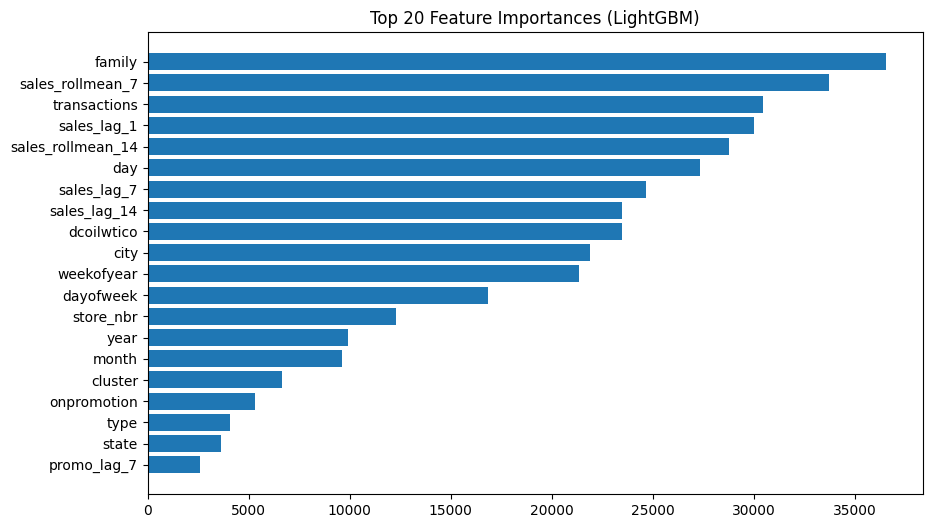

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    "feature": model.feature_name_,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance["feature"][:20],
         feature_importance["importance"][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()


In [69]:
import shap


In [71]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

In [1]:
shap.summary_plot(shap_values, x_valid)


NameError: name 'shap' is not defined

In [ ]:
shap.summary_plot(shap_values, X_valid, plot_type="bar")


In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    x_valid.iloc[0],
    matplotlib=True
)
